<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [1]:
# list available samples
from os import listdir
meshpath = './output_files/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]
mesh_list = ['test_NPR_rounded_h.xdmf',
             'test_NPR_rounded_v.xdmf']
# mesh_list = ['test_simplehole_discA1.xdmf',
#              'test_simplehole_discA2.xdmf',
#              'test_simplehole_discB1.xdmf',
#              ]

In [2]:
sample_height=1     #IMPORTANT TO CHECK       #height of the sample in the mesh file (m)

In [3]:
#Test loading profile
T_max = 40                                    #loading time length (s)
e_max = 0.003                                   #max upper boundary strain (no unit)
nb_steps = 15                                 #number of time steps during loading (default is 10)

In [4]:
# Mechanical Properties for sample design evaluation
# (default is given for steel https://www.matweb.com/search/datasheet.aspx?bassnum=MS0001&ckck=1 )

E_float = 200*1e9                                     #Young modulus (Pa)        default 200*1e9
nu_float = 0.25                                       #Poisson ratio (no unit)   default 0.25
sigma_y0_float = 350*1e6                              #Yield stress (Pa)         default 350*1e6

#MODEL PARAMETERS :
    #1-tanhplastic
sp=10
amp=0.1
    #2-perfectplasticity
#no parameters to define
    #3-

In [5]:
# To change the number of discrete segments to calculate anisotropy score :
# (default is 200)
n_seg=200
rel_thresh=1/3

# ↓ To run without editing ↓ 
## To avoid mistakes, use 'Run all'

### Imports

In [6]:
from IPython.display import Audio
sound_positive = './NOTIFICATION SOUNDS/mixkit-positive-notification-951.wav'
musical_reveal = './NOTIFICATION SOUNDS/mixkit-musical-reveal-961.wav'
from IPython.core.display import display
def beep_pos():
    display(Audio(sound_positive, autoplay=True))
def beep_reveal():
    display(Audio(musical_reveal, autoplay=True))


from fenics import *
from dolfin_adjoint import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3 import GapScore

#(((I don't know if it is useful
%reload_ext autoreload
#)))

### Load mesh and define function space

### Constitutive relation

In [7]:
def sigmoid(x):
    s = 1/(1+exp(-x))
    return s
def tanh(x):
    t = (exp(2*x)-1)/(exp(2*x)+1)
    return t

In [8]:
# Constitutive relation
def constitutive_relation(model,filename):
    MODELS = ['1-tanhplastic',
              '2-perfectplasticity'
             ]
    try:
        if not(constitutive_model in MODELS):
            raise NameError("UnknownModel : '{}' is not defined in MODELS".format(constitutive_model))
        else:
            print(constitutive_model)
    except NameError:
        raise NameError("ModelNotDefined : constitutive_model variable is not defined")

    E = Constant(E_float)
    nu = Constant(nu_float)
    sigma_y0 = Constant(sigma_y0_float)
    mu = E/2/(1+nu)
    lmbda = E*nu/(1+nu)/(1-2*nu)
    lmbda = 2*mu*lmbda/(lmbda+2*mu)    

    if constitutive_model=='1-tanhplastic':
        try:
            filename.split('/res')[0]+=" -- sp={} , amp={}".format(sp,amp)+"/res"
        except NameError:
            raise NameError("ModelParamNotDefined : you need to define sp and amp. Default would be amp=0.1 and sp=10.")
    
    global epsilon, sigma_el, sigma_yield, epsilon_pl, Constitutive_function
    def epsilon(u):
        return sym(grad(u))

    def sigma_el(epsilon):
        return lmbda*tr(epsilon)*Identity(2) + 2*mu*epsilon

    def sigma_yield(epsilon):
        if constitutive_model == '1-tanhplastic':
            return sigma_y0 + amp*sigma_y0*tanh(epsilon*sp)
        if constitutive_model == '2-perfectplasticity':
            return sigma_y0

    def epsilon_pl(d_epsilon, sigma_old, epsilon_old,kappa_value=100):
        '''
        inputs
        d_epsilon: strain increment
        sigma_old: stress tensor at the increment n
        epsilon_old: plastic strain tensor
        kappa_value: sharpness of the sigmoid function
        '''
        kappa = Constant(kappa_value)

        sigma_y = sigma_yield(epsilon_old)
        H = diff(sigma_y, epsilon_old)

        sigma_pr = sigma_old + sigma_el(d_epsilon) # trial stress
        sigma_pr_dev = dev(sigma_pr) # deviatoric elastic stress
        sigma_ef = sqrt(3/2.*inner(sigma_pr_dev, sigma_pr_dev) + DOLFIN_EPS) # effective von Mises stress

        sgn = (sigma_ef - sigma_y)/(abs(sigma_ef - sigma_y) + DOLFIN_EPS)
        f_sigmoid = sigmoid(kappa*(sigma_ef - sigma_y)*sgn) # the indicator function
        f_ind = (f_sigmoid-0.5)*sgn + 0.5

        d_epsilon_pl_sc = f_ind*(sigma_ef - sigma_y)/(3*mu + H) # plastic strain increment (scalar)
        n_pr = dev(sigma_pr) / sigma_ef
        d_epsilon_pl = d_epsilon_pl_sc*3/2*n_pr

        return d_epsilon_pl
    
    def Constitutive_function(sig_n, du, ep_n, dt=1E-3):
        d_epsilon_el = epsilon(du) # elastic strain increment
        d_epsilon_pl = epsilon_pl(d_epsilon_el,sig_n,ep_n) # plastic strain increment
        d_epsilon = d_epsilon_el - d_epsilon_pl
        dot_p = sqrt(inner(d_epsilon_pl,d_epsilon_pl)*2.0/3.0 + DOLFIN_EPS) #Accumulated plastic strain rate
        return sig_n + sigma_el(d_epsilon), dot_p

In [9]:
def mis_ep(u):
    eps_dev = epsilon(u) - Identity(2)*tr(epsilon(u))
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sig(sig):
    sigma_dev = sig - Identity(2)*tr(sig)
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis

In [10]:
threshold = rel_thresh*sigma_y0_float**2

In [11]:
def solve_plastic_system_and_score(mesh, Dn,Tn, constitutive_func, loss_func=lambda n,x: 0,
                         tol = 1.0E-14, filepath="./resultstester_GAP/",THR=threshold,N_seg=200):
        
    if len(Dn)!=len(Tn) : raise NameError("ProfileListsNotSameLen")
    num_stps=len(Dn)
    
    # Define function space for displacement
    S = FunctionSpace(mesh, 'P', 1)
    V = VectorFunctionSpace(mesh, 'P', 1)
    T = TensorFunctionSpace(mesh, 'P', 1)
    
    # Define test functions
    v  = TestFunction(V)
    du = TrialFunction(V)
    
    # Define functions for dsiplacement
    u     = Function(V)
    u_n   = Function(V)
    sig   = Function(T)
    sig_n = Function(T)
    ep    = Function(S)
    ep_n  = Function(S)

    # Define boundary 
    def BC_y0(x, on_boundary):
        return on_boundary and near(x[1], 0, 1e-3)
    def BC_y1(x, on_boundary):
        return on_boundary and near(x[1], 1, 1e-3)
    bcD = DirichletBC(V.sub(1), 0,    BC_y0)
    def BC_corner(x, on_boundary):
        return near(x[1], 0, tol) and near(x[0], 0, 2e-2)
    bc_corner = DirichletBC(V.sub(0), 0,    BC_corner)
    
    
    # Time-stepping
    t = Tn[0]
    results = []
    
    File_displacement = File(filepath+'displacement_AG.pvd')
    File_stress_Mis = File(filepath+'stress_Mis_AG.pvd')
    File_strain_Mis = File(filepath+'strain_Mis_AG.pvd')
    File_strain_AG = File(filepath+'strain_AG.pvd')
    File_stess_AG = File(filepath+'stess_AG.pvd')
    
    array_u = np.zeros((n_elements,2,num_stps+1))
    array_sigma = np.zeros((n_elements,2,2,num_stps+1))
    array_epsilon = np.zeros((n_elements,2,2,num_stps+1))
    
    for n in tqdm(range(num_stps)):
        print(n)
        displacement = Dn[n]
        bcU = DirichletBC(V.sub(1), displacement, BC_y1)
        BC = [bcU, bcD, bc_corner]
        
        # Define variational problem
        if n==0:
            dt=0
        if n>0:
            dt=Tn[n]-Tn[n-1]
        sig, dep = constitutive_func(sig_n, u-u_n, ep_n, dt=dt)
        F = inner(sig, epsilon(v))*dx
        
        # Update current time
        t = Tn[n]
        
        # Solve variational problem for time step
        J = derivative(F, u, du)
        problem = NonlinearVariationalProblem(F, u, BC, J)
        solver = NonlinearVariationalSolver(problem)
        solver.solve()
        
        # Update previous solution
        sig = project(sig, T)
        ep = project(ep_n+dep, S)
        
        sig_n.assign(sig)
        u_n.assign(u)
        ep_n.assign(ep)
        print('end')
        
        # Save solution to file in VTK format
        sig_Mis = project(mis_sig(sig),S)
        ep_Mis = project(mis_ep(u),S)
#         sig_Mis = mis_sig(sig)
#         ep_Mis = mis_ep(u)
        epsilon_u = epsilon(u)
        
        u.rename('$u$','displacement')
        sig.rename('$\sigma$','stress')
        ep.rename('$\epsilon$','strain')
        sig_Mis.rename('$\sigma_{VM}$','stress_Mis')
        ep_Mis.rename('$\epsilon_{VM}$','strain_Mis')
        
        File_displacement << (u,t)
        File_stress_Mis << (sig_Mis,t)
        File_strain_Mis << (ep_Mis,t)
        File_strain_AG << (ep,t)
        File_stess_AG << (sig,t)
        
        # Save element vectors in .mat format
        from scipy.io import savemat
        array_u[:,:,n] = np.array(u.vector()).reshape(n_elements,2)
        
        epsilon_u = epsilon(u)
        epsilon_u = project(epsilon(u),T)
        array_epsilon[:,:,:,n] = np.array(epsilon_u.vector()).reshape(n_elements,2,2)
        
        array_sigma[:,:,:,n] = np.array(sig.vector()).reshape(n_elements,2,2)
        
        plot(sig_Mis, mode='color')
        plt.title("Equivalent Von Mises stress in the sample at step {}".format(n))
        plt.show()
        
    PTSSTRESS=[]
    for n in range(n_elements):
        for st in range(num_stps+1):
            PTSSTRESS+=[[(array_sigma[n,0,0,st]-array_sigma[n,1,1,st])/2,array_sigma[n,0,1,st]]]
    
    mdic = {'u':array_u, 'epsilon':array_epsilon, 'sigma':array_sigma}
    savemat(filepath+'data.mat', mdic)
    
#     beep_pos()
    
    S = FunctionSpace(mesh, 'P', 2)
    sigma_Mis = project(mis_sig(sig),S)
    plot(sig_Mis, mode='color')
    plt.title("Equivalent Von Mises stress in the sample")
    plt.show()
    
    PTSSTRESS = np.array(PTSSTRESS)
    plt.plot(PTSSTRESS[:,0],PTSSTRESS[:,1],marker='o',markersize=0.3,linewidth=0)
    plt.title("Stress paths")
    plt.show()
    
    PTSSTRESS_yield=[]
    for X in PTSSTRESS:
        if X[0]**2+X[1]**2>=THR:
            PTSSTRESS_yield+=[X]
    PTSSTRESS_yield=np.vstack(PTSSTRESS_yield)
    print("nb_annular_points : "+str(len(PTSSTRESS_yield)))
    Score=GapScore(PTSSTRESS_yield,threshold=0.85,tol=1e-14)
    plt.plot(PTSSTRESS_yield[:,0],PTSSTRESS_yield[:,1],marker='o',markersize=0.3,linewidth=0)
    plt.title("Stress paths : anisotropy score = "+str(Score)[0:7])
    plt.show()
    
    
    return ep, sig, u, sig_Mis, ep_Mis, PTSSTRESS, Score

Mesh:test_NPR_rounded_h -- T_max=40,e_max=0.003,nb_steps=15 -- n_seg=200,rel_thresh=0.3333333333333333 -- model : 1-tanhplastic -- E=200000000000.0,nu=0.25,sigma_y0=350000000.0/res
1-tanhplastic
1117 elements in mesh


  0%|          | 0/15 [00:00<?, ?it/s]

0
end


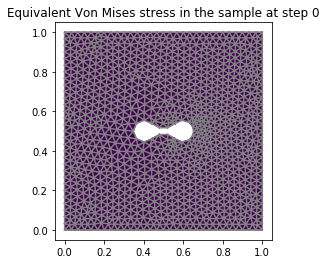

  7%|▋         | 1/15 [00:01<00:22,  1.62s/it]

1
end


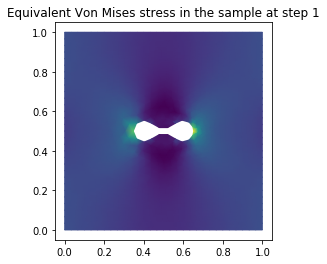

 13%|█▎        | 2/15 [00:04<00:29,  2.30s/it]

2
end


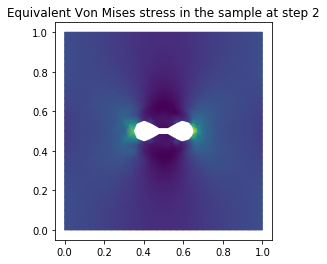

 20%|██        | 3/15 [00:07<00:30,  2.55s/it]

3
end


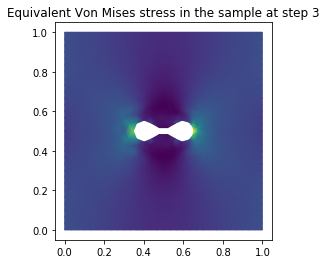

 27%|██▋       | 4/15 [00:14<00:46,  4.23s/it]

4
end


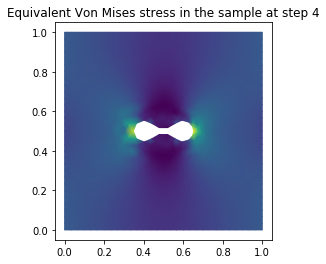

 33%|███▎      | 5/15 [00:23<00:59,  5.96s/it]

5
end


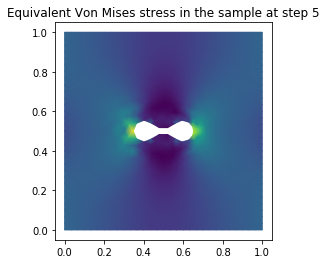

 40%|████      | 6/15 [00:32<01:03,  7.10s/it]

6
end


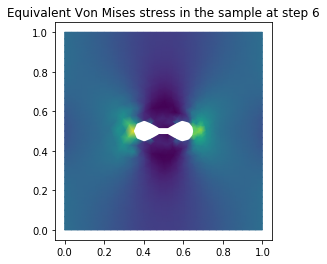

 47%|████▋     | 7/15 [00:43<01:08,  8.51s/it]

7
end


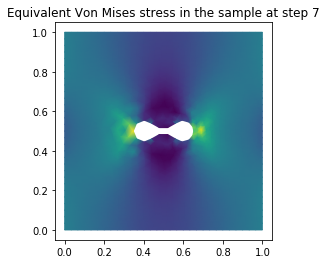

 53%|█████▎    | 8/15 [00:54<01:03,  9.08s/it]

8
end


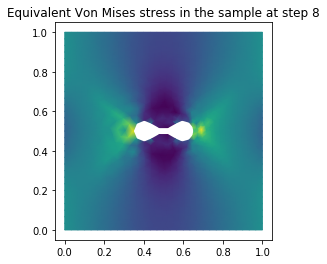

 60%|██████    | 9/15 [01:04<00:56,  9.36s/it]

9
end


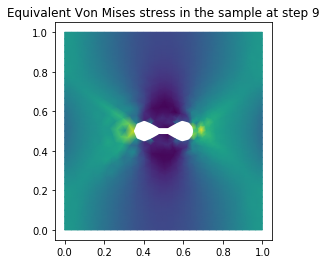

 67%|██████▋   | 10/15 [01:14<00:47,  9.58s/it]

10
end


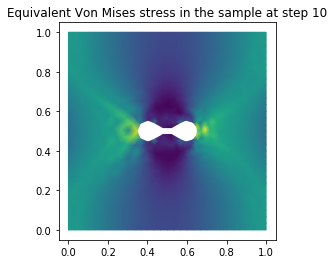

 73%|███████▎  | 11/15 [01:25<00:40, 10.10s/it]

11
end


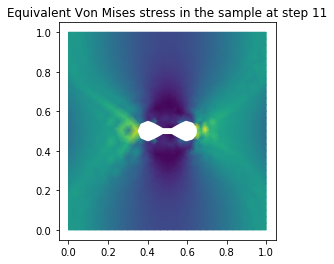

 80%|████████  | 12/15 [01:36<00:31, 10.46s/it]

12
end


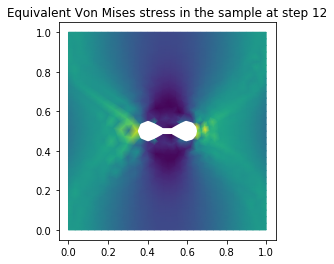

 87%|████████▋ | 13/15 [01:48<00:21, 10.88s/it]

13
end


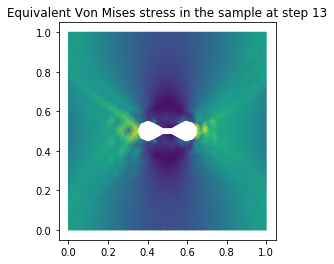

 93%|█████████▎| 14/15 [01:59<00:11, 11.03s/it]

14
end


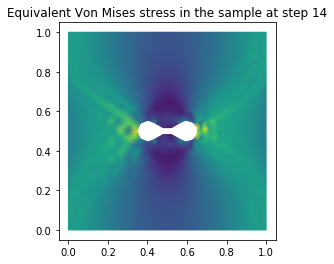

100%|██████████| 15/15 [02:11<00:00,  8.76s/it]


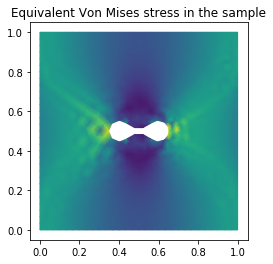

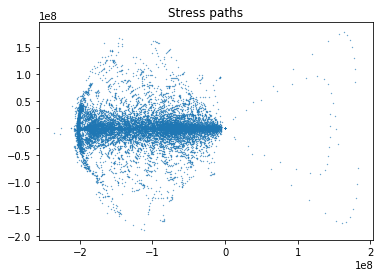

nb_annular_points : 1589


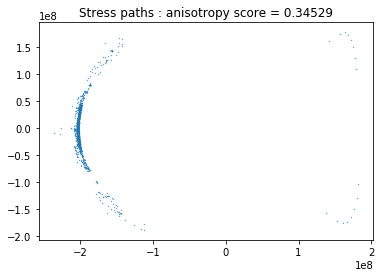

Mesh:test_NPR_rounded_v -- T_max=40,e_max=0.003,nb_steps=15 -- n_seg=200,rel_thresh=0.3333333333333333 -- model : 1-tanhplastic -- E=200000000000.0,nu=0.25,sigma_y0=350000000.0/res
1-tanhplastic
628 elements in mesh


  0%|          | 0/15 [00:00<?, ?it/s]

0
end


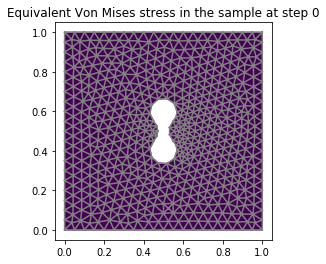

  7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

1
end


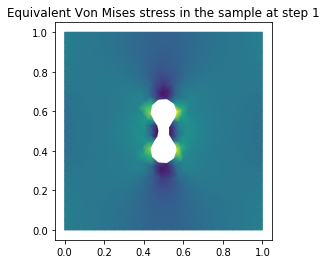

 13%|█▎        | 2/15 [00:02<00:19,  1.52s/it]

2
end


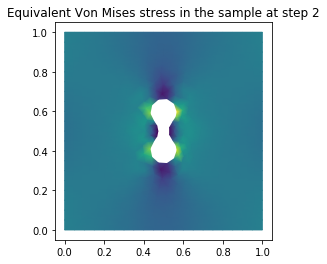

 20%|██        | 3/15 [00:04<00:19,  1.66s/it]

3
end


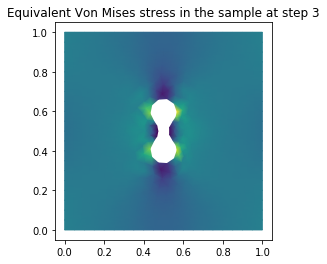

 27%|██▋       | 4/15 [00:06<00:18,  1.70s/it]

4
end


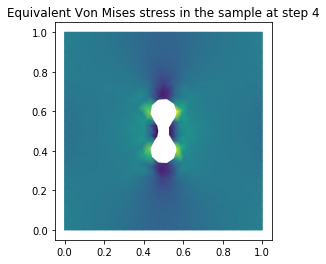

 33%|███▎      | 5/15 [00:08<00:17,  1.74s/it]

5
end


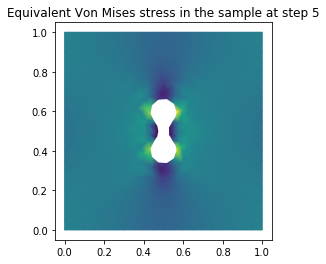

 40%|████      | 6/15 [00:12<00:23,  2.56s/it]

6
end


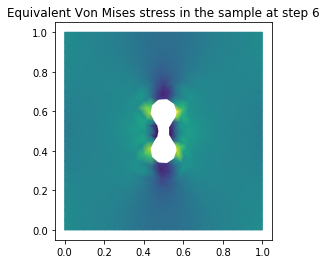

 47%|████▋     | 7/15 [00:17<00:26,  3.33s/it]

7
end


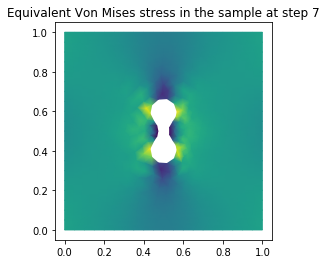

 53%|█████▎    | 8/15 [00:22<00:27,  3.86s/it]

8


 53%|█████▎    | 8/15 [01:01<00:53,  7.70s/it]

test_NPR_rounded_v.xdmf


In [12]:
Dn_test=list(np.linspace(0,e_max*sample_height,nb_steps))
Tn_test=list(np.linspace(0,T_max,nb_steps))

for i in range(len(mesh_list)):
    try:
        #### Meshfile ####
        meshfile = mesh_list[i]                  # with .xdmf
        meshpath = './output_files/'
        constitutive_model = '1-tanhplastic'

        #### Define output filename ####
        # date&time
        from datetime import datetime
        # datetime object containing current date and time
        now = datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%Y/%m/%d %H:%M:%S")

        filename = "Mesh:"+meshfile.split('.')[0]+" -- T_max={},e_max={},nb_steps={} -- n_seg={},rel_thresh={} -- model : {} -- E={},nu={},sigma_y0={}/res".format(
        T_max,e_max,nb_steps,n_seg,rel_thresh,constitutive_model,E_float,nu_float,sigma_y0_float)
        print(filename)

        outname = "output_"+filename+".xdmf"
        outdata = "ForcevsDisp_"+filename+".txt"

        #### constitutive_relation #### 
        constitutive_relation(constitutive_model,filename)

        #### load mesh #### 
        mesh = Mesh()
        with XDMFFile(meshpath+meshfile) as xdmf_infile:
            xdmf_infile.read(mesh)
        n_elements = mesh.coordinates().shape[0]
        print(str(n_elements)+" elements in mesh")
        plot(mesh)
        plt.savefig(meshpath+meshfile+'.png', dpi=96, bbox_inches='tight')

        ep, sig, u, sig_Mis, ep_Mis, PTSSTRESS, Score = solve_plastic_system_and_score(mesh, Dn_test,Tn_test, Constitutive_function, THR=threshold, filepath='./resultstester_GAP/'+meshfile+'/')
        Score_stress = Score
    
    except:
        print(meshfile)
        pass